In [68]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [69]:
sns.set_theme(style="darkgrid", palette=sns.mpl_palette("viridis"))

In [70]:
input_file = r"tiny_eeg_self_experiment_reading_music.xls"

In [71]:
excelFile = pd.read_excel(input_file, sheet_name=["Music","Reading"])

df_music = excelFile["Music"]
df_reading = excelFile["Reading"]

In [72]:
print("=========== MUSIC INFO ===========")
print(df_music.info())
print("=========== READING INFO ===========")
print(df_reading.info())

=========== MUSIC INFO ===========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16383 entries, 0 to 16382
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IndexId   16383 non-null  int64  
 1   Channel1  16383 non-null  float64
 2   Channel2  16383 non-null  float64
 3   Channel3  16383 non-null  float64
 4   Channel4  16383 non-null  float64
 5   Ref1      16383 non-null  int64  
 6   Ref2      16383 non-null  int64  
 7   Ref3      16383 non-null  int64  
 8   TS1       16383 non-null  object 
 9   TS2       16383 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.3+ MB
None
=========== READING INFO ===========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16383 entries, 0 to 16382
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IndexId   16383 non-null  int64  
 1   Channel1  16383 non-null  float64
 2   Channel2  1638


## Limpieza de datos

### Dataset Musica

In [73]:
df_music = df_music.drop(labels=["IndexId","Ref1","Ref2","Ref3","TS1","TS2"],axis=1)
df_music.head()

,Channel1,Channel2,Channel3,Channel4
0,933.19,519.23,21.71,238.45
1,932.94,516.98,22.70,251.80
2,827.70,521.87,17.26,207.42
3,893.26,519.82,18.90,219.49
4,953.94,520.69,21.88,252.06


In [74]:
len(df_music)

16383

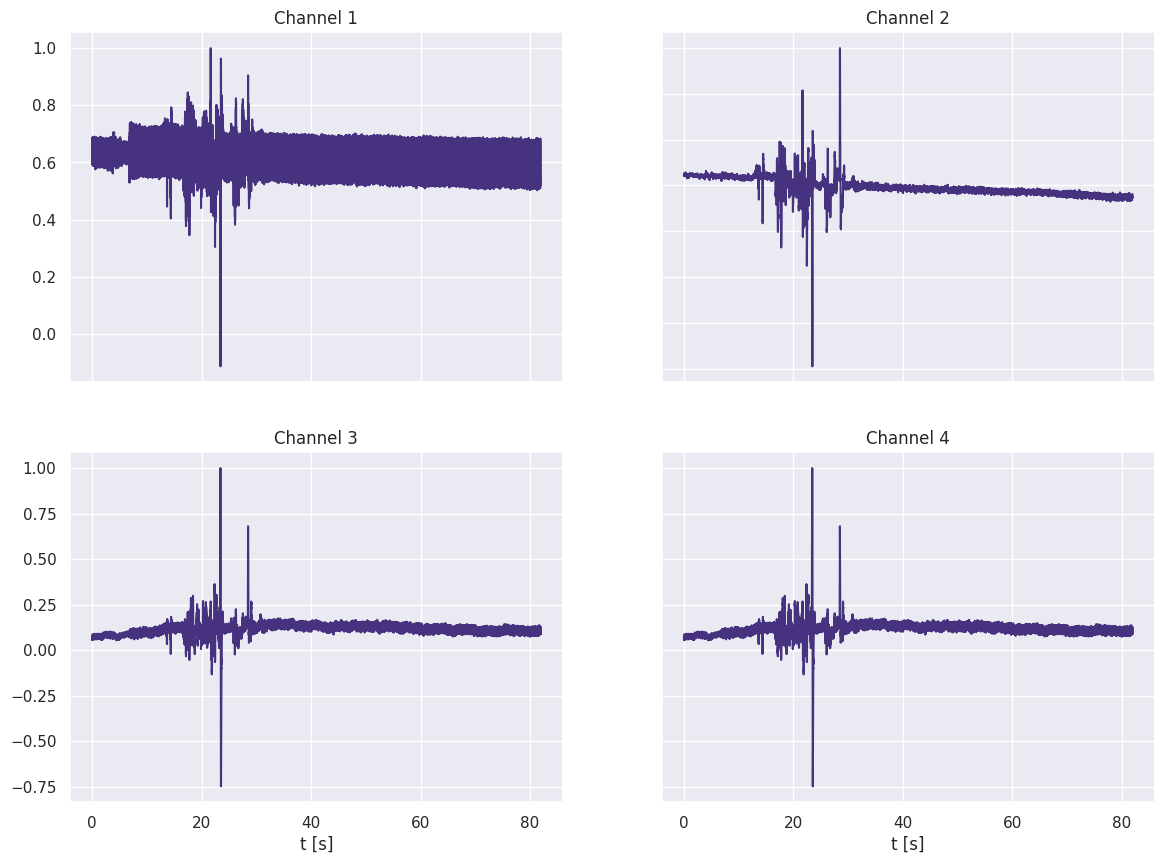

In [75]:
#sampling rate del ganglion board es de 200 Hz
fs = 200
T = 1/fs * len(df_music)
t = np.linspace(0,T,len(df_music))

#Normalizamos los canales

channels = [df_music[f"Channel{i}"] for i in range(1,5)]

[CH1, CH2, CH3, CH4] = channels

CH1 = CH1 / np.max(CH1)
CH2 = CH2 / np.max(CH2)
CH3 = CH3 / np.max(CH3)
CH4 = CH4 / np.max(CH4)

fig, axs = plt.subplots(2,2,figsize=(14,10))

axs[0,0].plot(t, CH1)
axs[0,0].set_title("Channel 1")
axs[0,1].plot(t, CH2)
axs[0,1].set_title("Channel 2")
axs[1,0].plot(t, CH3)
axs[1,0].set_title("Channel 3")
axs[1,1].plot(t, CH3)
axs[1,1].set_title("Channel 4")

for ax in axs.flat:
  ax.set(xlabel="t [s]")

for ax in axs.flat:
  ax.label_outer()

channels = [CH1, CH2, CH3, CH4]

#### Usando FFT

In [76]:
#Funcion para plotear
def plot_channels(channels_fft, freq, titles=None):
    plt.clf()
    fig, axs = plt.subplots(2, 2, figsize=(14,10))
    axs = axs.flatten()

    if titles is None:
        titles = [f"CH{i+1}" for i in range(len(channels_fft))]
    
    for ax, ch_fft, title in zip(axs, channels_fft, titles):
        ax.plot(freq, np.abs(ch_fft), lw=1.0)
        ax.stem(freq, np.abs(ch_fft))
        ax.set_title(f"$|\mathcal{{F}}({title})|$")
        ax.set_xlabel("Frecuencia [Hz]")
        ax.set_ylabel("Amplitud [u.a]")
    
    plt.tight_layout()
    plt.show()

In [77]:
#Función que calcula todas las transformadas de fourier
def RFFT_CH(channels, fs, freq_size):
    channels_fft = []
    freq = np.fft.rfftfreq(freq_size, 1/fs)

    for ch in channels:
        channels_fft.append(np.fft.rfft(ch))

    return channels_fft, freq

<Figure size 640x480 with 0 Axes>

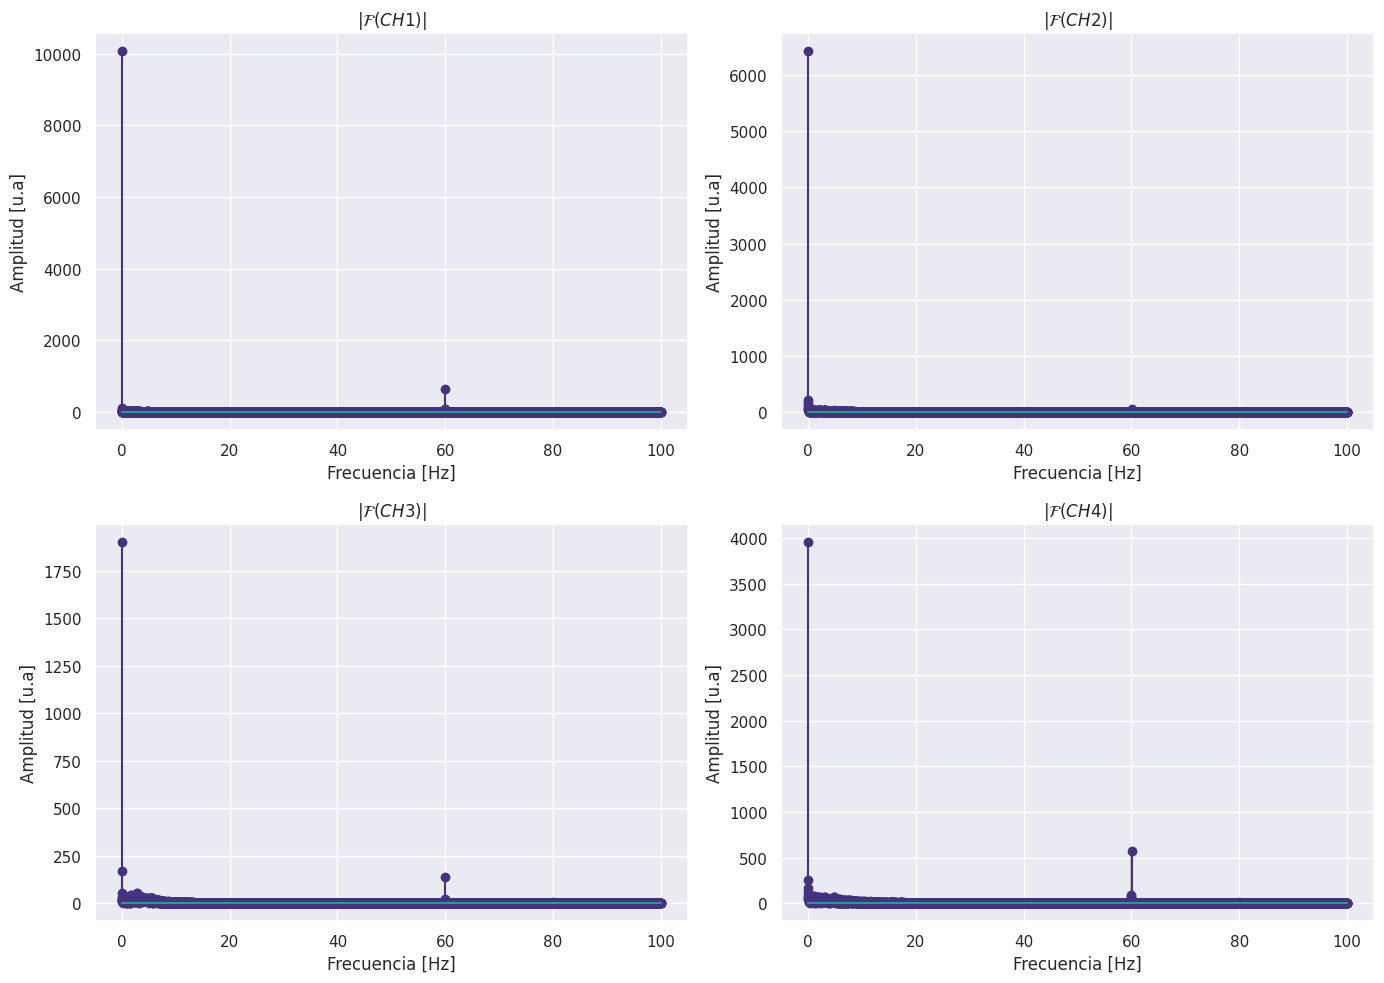

In [78]:
channels_fft, freq = RFFT_CH(channels=channels, fs=fs, freq_size=np.size(t))

plot_channels(channels_fft=channels_fft, freq=freq)

In [79]:
#función para filtrar amplitudes muuy altas
def FST_FILT(channels, amp):
    for ch in channels:
        ch[np.abs(ch) > amp] = 0

<Figure size 640x480 with 0 Axes>

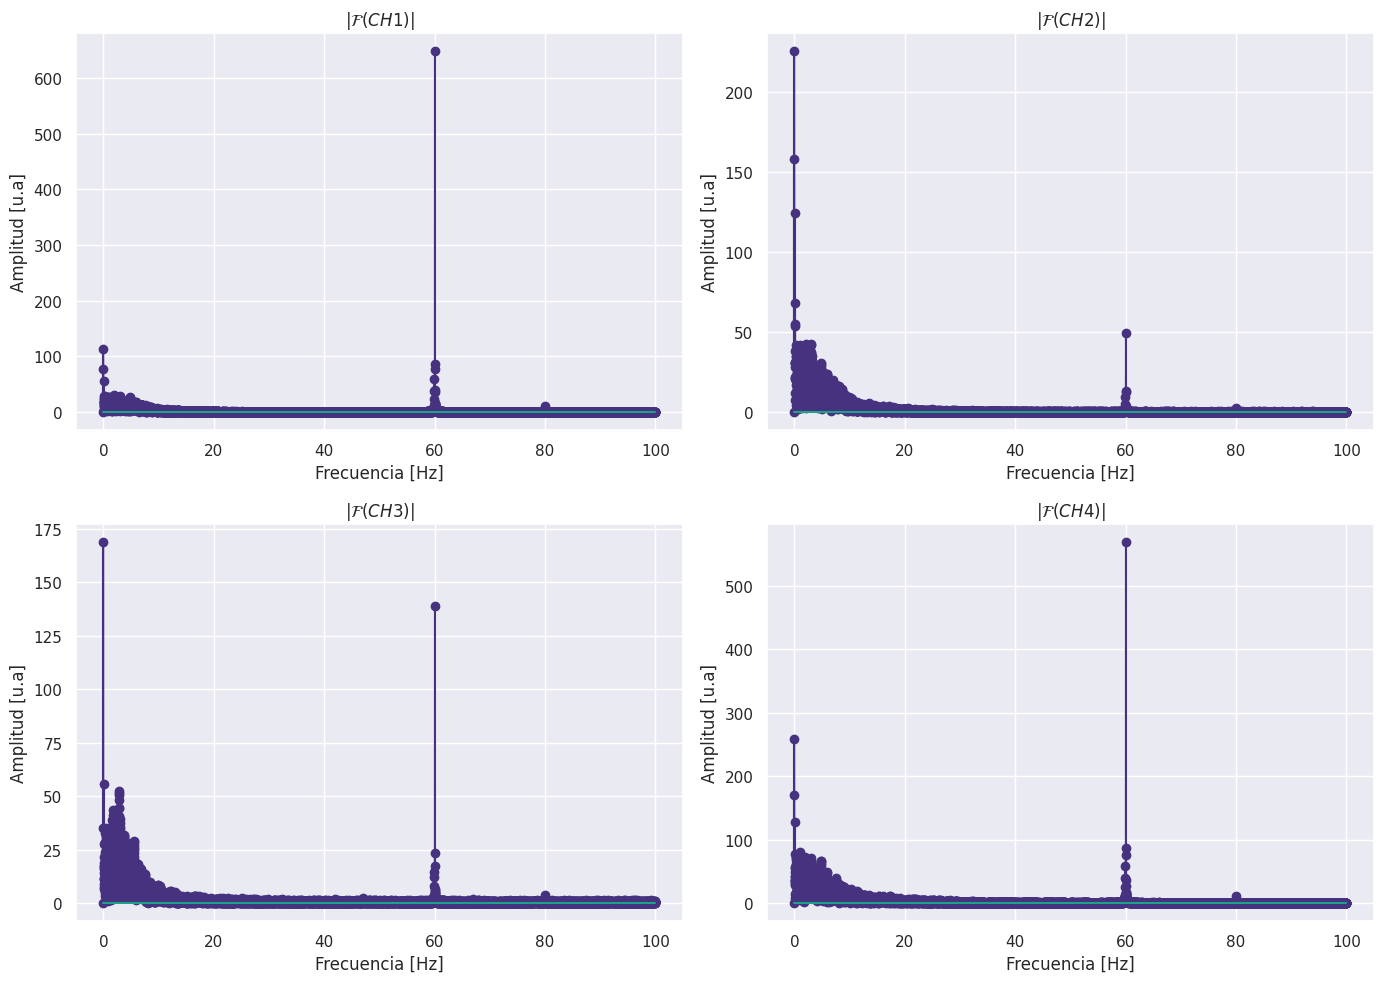

In [80]:
FST_FILT(channels=channels_fft, amp=1500)
plot_channels(channels_fft=channels_fft, freq=freq)

In [81]:
#Boxplot de todos los canales para saber si es necesario filtrar outliers
def boxplot(channels):
    plt.clf()
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    for i, (ch_fft, ax) in enumerate(zip(channels, axs.flatten())):
        sns.boxplot(np.abs(ch_fft), showfliers=True, log_scale=True, orient='h', ax=ax)
        ax.set_xlabel("Frecuencia")
        ax.set_ylabel("Amplitud")
        ax.set_title(f"CH{i+1}")

    for ax in axs.flat:
        ax.set(xlabel="frecuencia [Hz]", ylabel="amplitud [u.a]")

    for ax in axs.flat:
        ax.label_outer()
    
    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

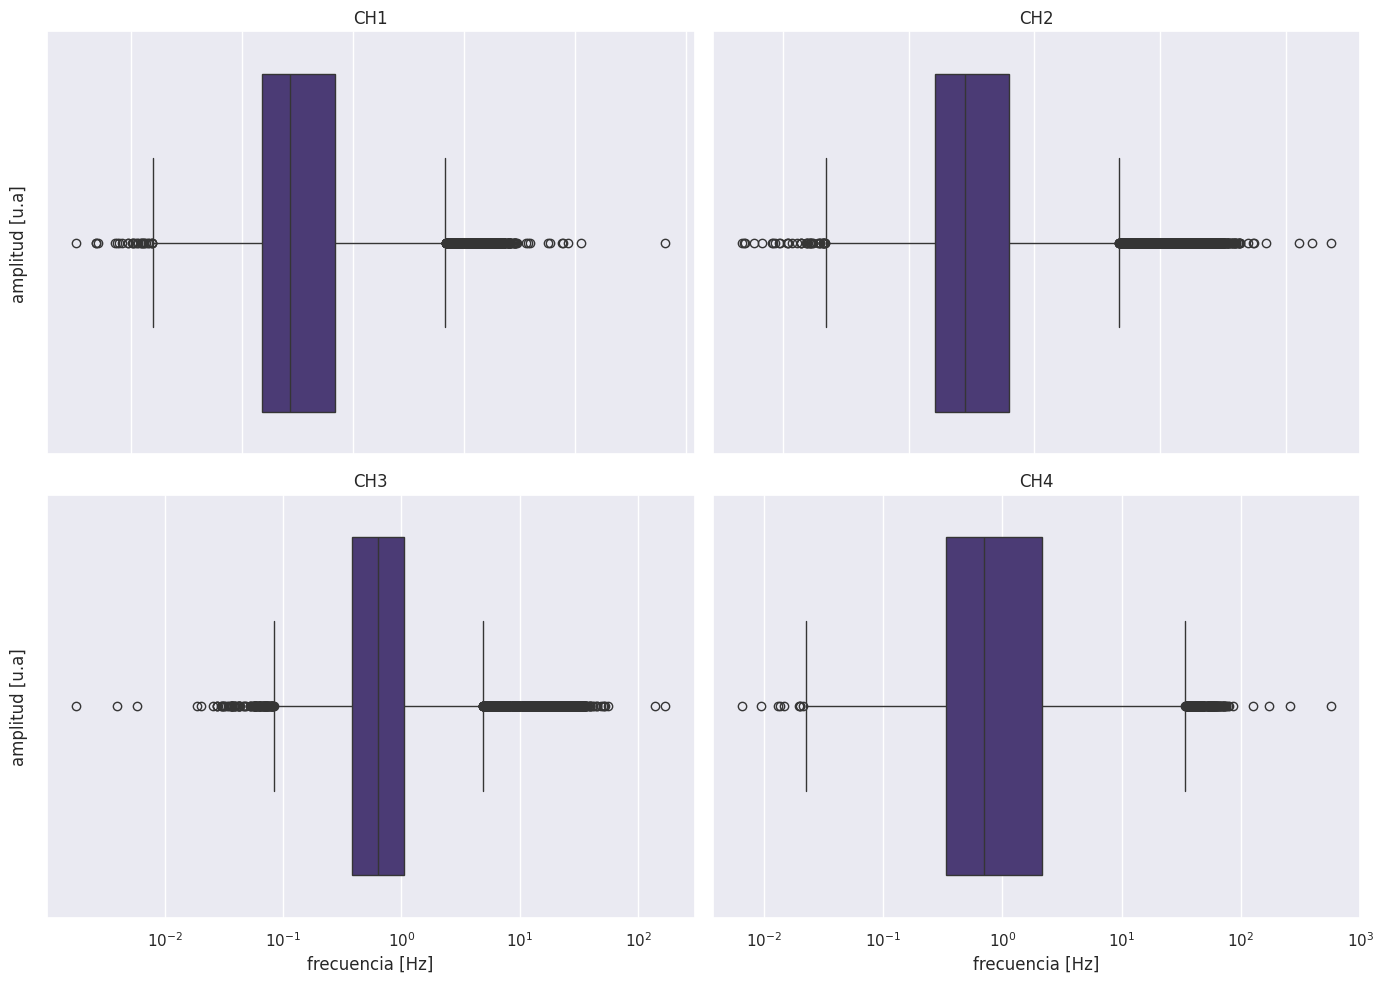

In [82]:
#Busqueda de outliers!
boxplot(channels_fft)

In [83]:
#funcion para remover outliers usando zscore
def rm_outl(channels, treshold):
    for ch in channels:
        z_scores = sp.stats.zscore(np.abs(ch))
        ch[z_scores > treshold] = 0

<Figure size 640x480 with 0 Axes>

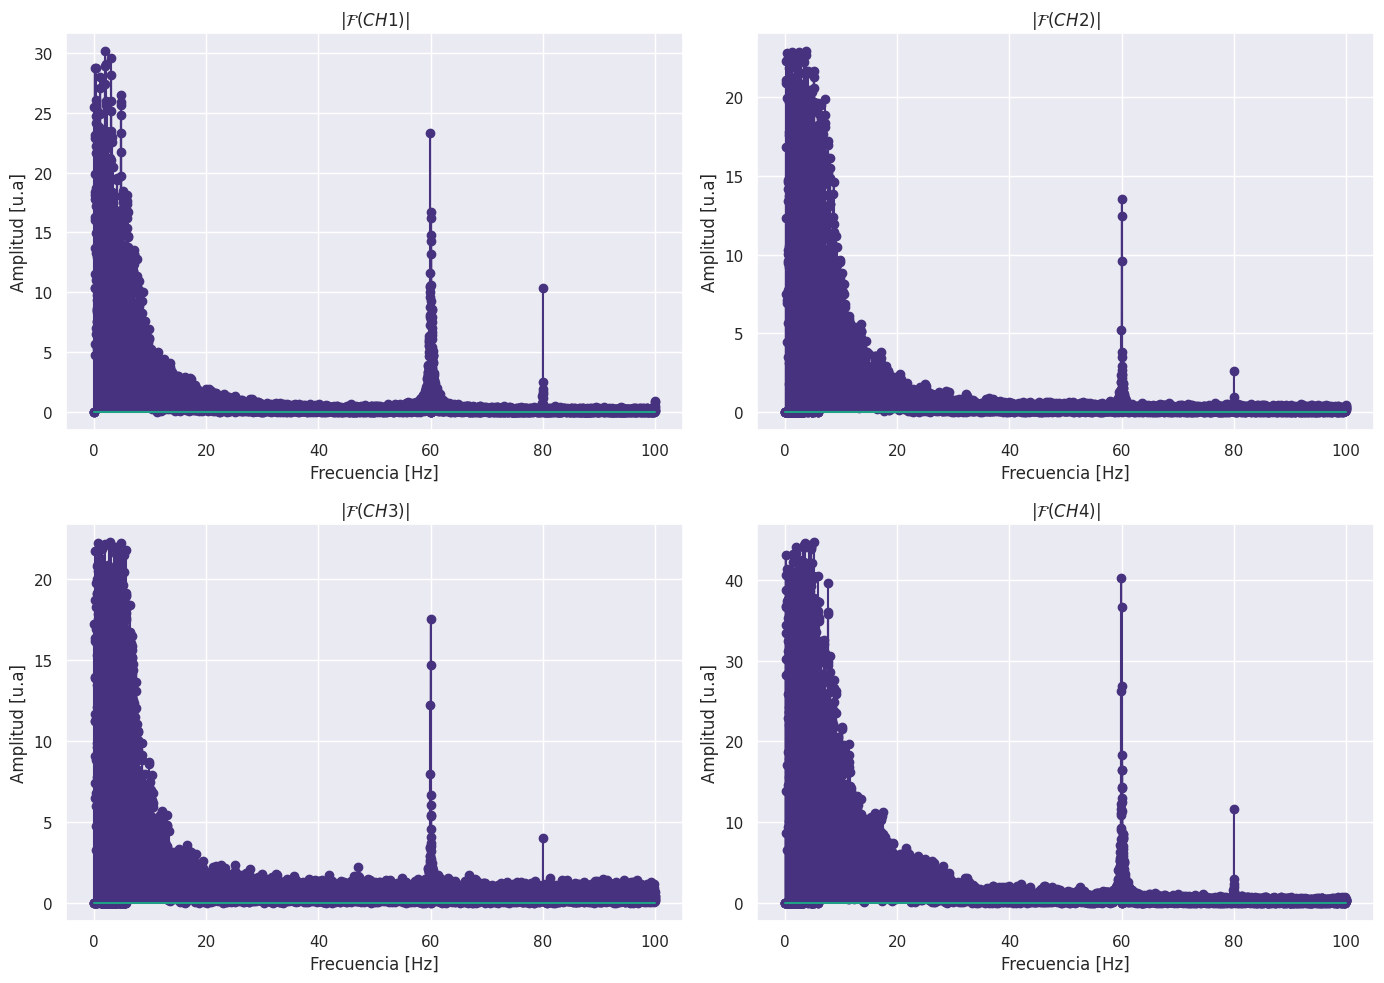

In [84]:
rm_outl(channels=channels_fft, treshold=3.5)
plot_channels(channels_fft=channels_fft, freq=freq)

<Figure size 640x480 with 0 Axes>

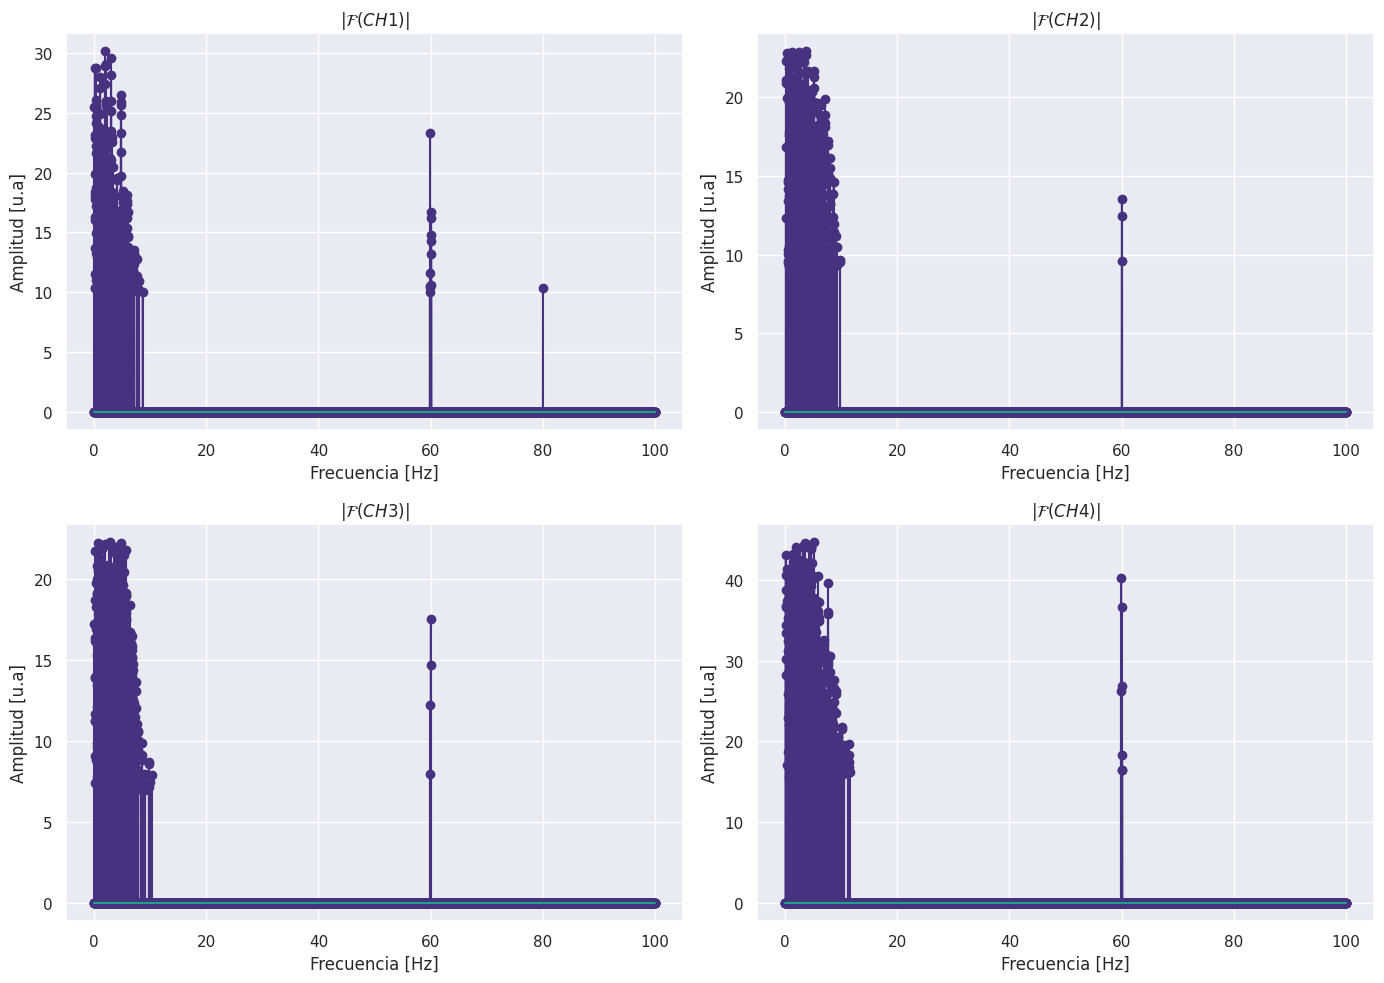

In [85]:
#Filtramos frecuencias de cada canal segun el grafico anterior
cuts = [10,9,7,15]

for c, ch in zip(cuts, channels_fft):
    ch[np.abs(ch) < c] = 0

plot_channels(channels_fft=channels_fft, freq=freq)

In [86]:
#Reconstruir señales
channels_rec_mus = []
for ch in channels_fft:
    channels_rec_mus.append(np.fft.irfft(ch))

In [87]:
CH1_rec = channels_rec_mus[0]
CH1_rec

array([ 0.00415034,  0.00741708,  0.00582363, ..., -0.00685974,
       -0.00393475, -0.00603733])

In [88]:
#ploteamos las originales vs las nuevas
def plot_comparison(channels, reconstructed, t, Tmax):
    plt.clf()
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    for i, (ch,ch_fft, ax) in enumerate(zip(channels, reconstructed,axs.flatten())):
        ts = np.linspace(0,Tmax, len(ch_fft))
        ax.plot(t, ch, lw=1, label="Original")
        ax.plot(ts, ch_fft, c="darkcyan", label="Reconstruida")
        ax.set_xlabel("Tiempo [s]")
        ax.set_title(f"CH{i+1}")
        ax.set_xticks([])
        ax.set_yticks([])

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    
    for ax in axs.flat:
        ax.label_outer()
    
    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

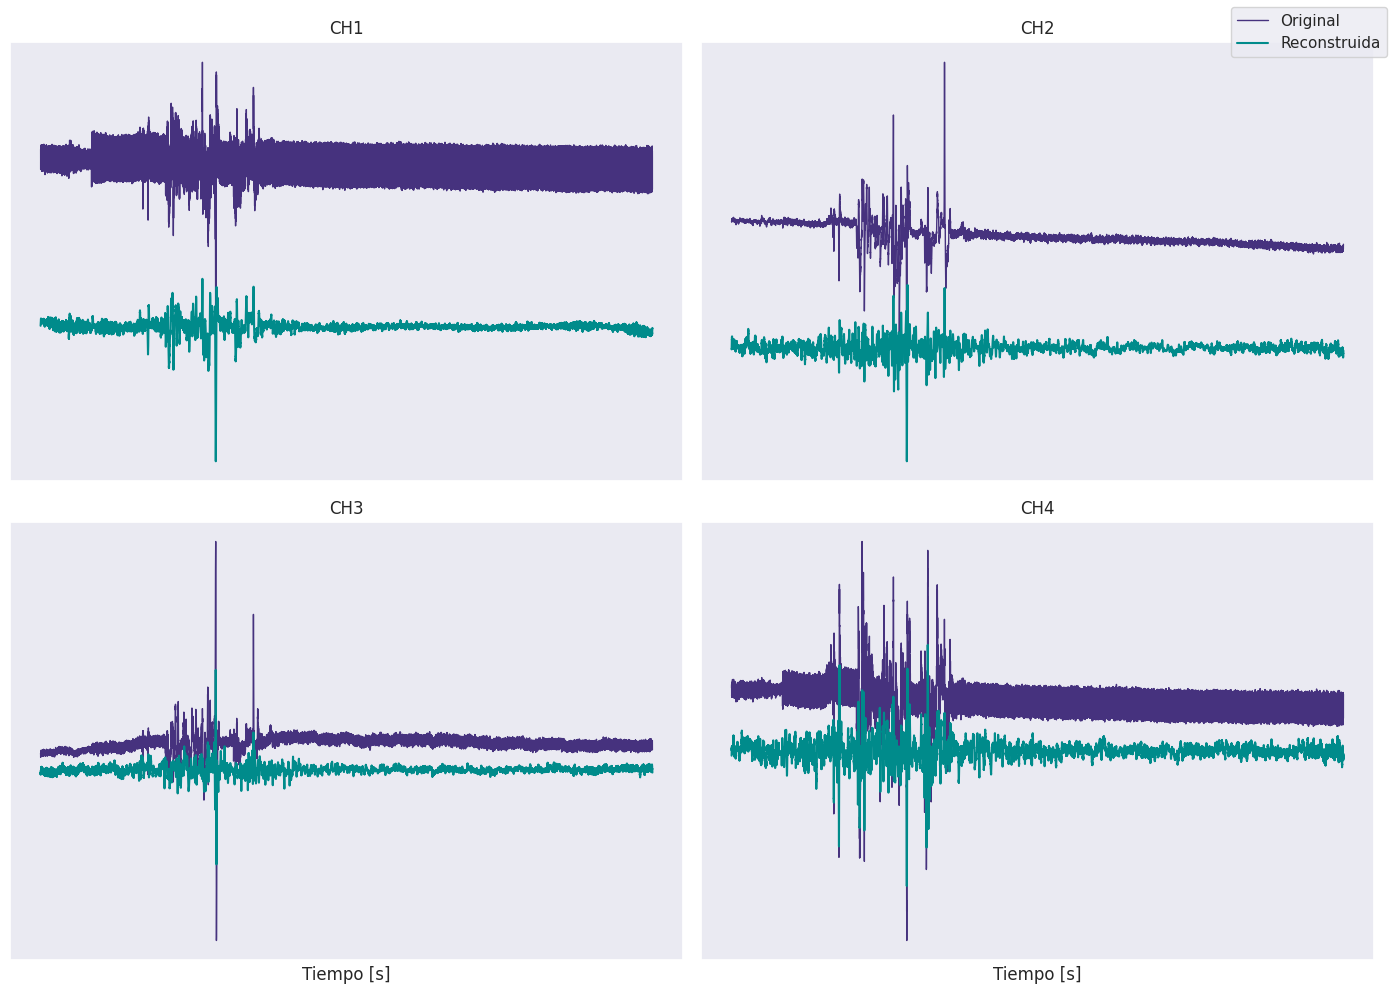

In [89]:
plot_comparison(channels=channels, reconstructed=channels_rec_mus, t=t, Tmax=T)

In [90]:
#Close up de las primeras n muestras
def close_up(channels, n, Tmax):
    plt.clf()
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    for i, (ch, ax) in enumerate(zip(channels, axs.flatten())):
        ch_cu = ch[:n]
        ts = np.linspace(0,Tmax, len(ch))
        ts = ts[:n]
        ax.plot(ts, ch_cu)
        ylim = (np.min(ch_cu), np.max(ch_cu))
        ax.set_ylim(ylim)
        ax.set_xlabel("Tiempo [s]")
        ax.set_title(f"CH{i+1}")
        ax.set_xticks([])
        ax.set_yticks([])
    
    for ax in axs.flat:
        ax.label_outer()
    
    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

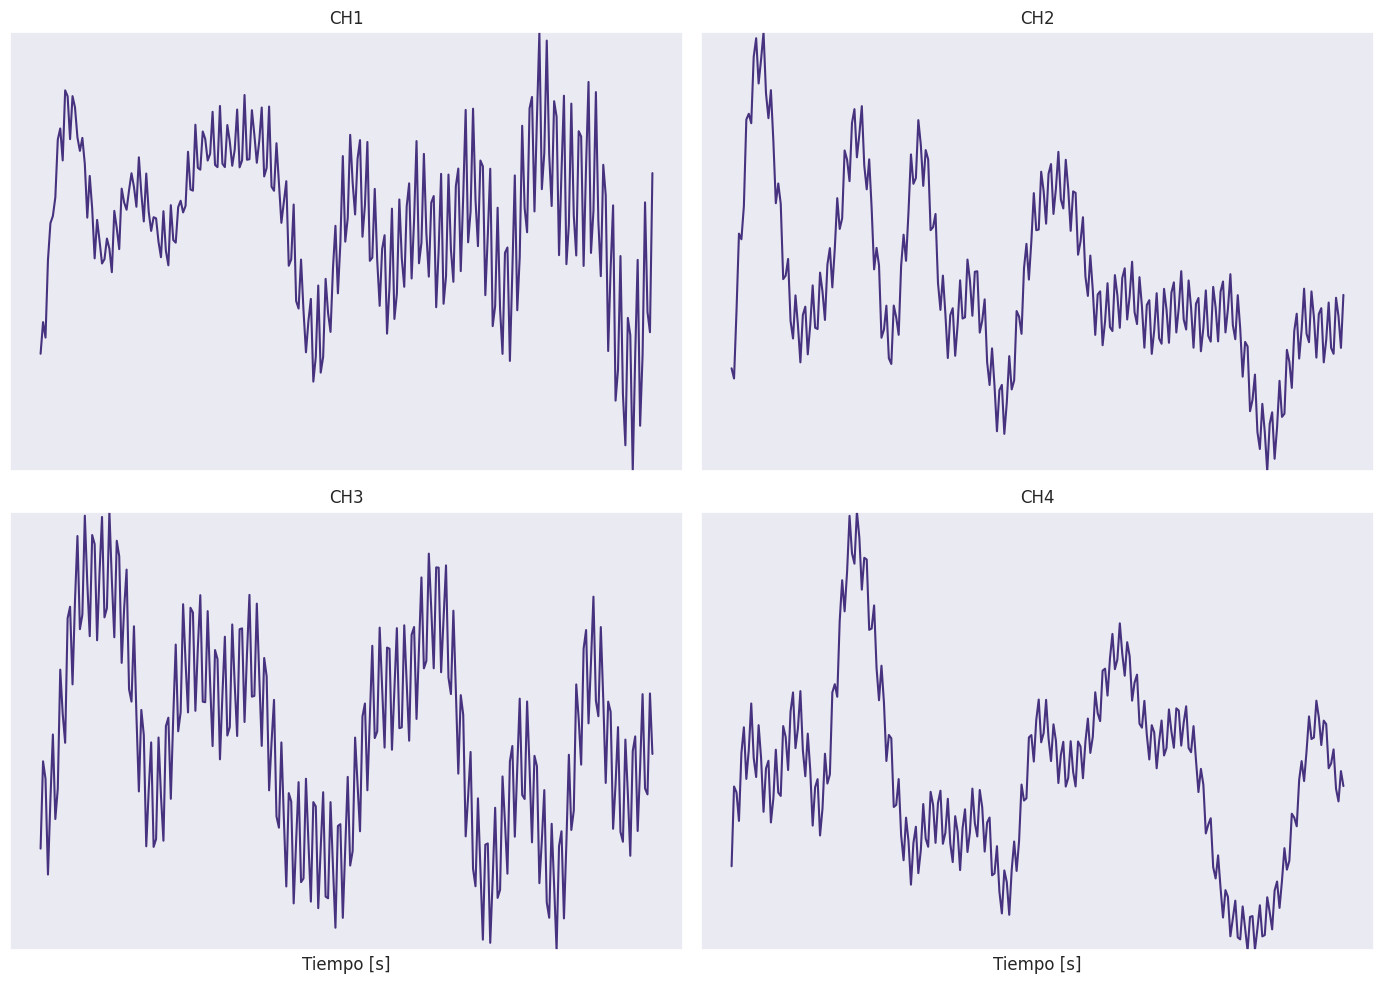

In [91]:
close_up(channels_rec_mus, 250, Tmax=T)

### Dataset de lectura

In [92]:
df_reading = df_reading.drop(labels=["IndexId","Ref1","Ref2","Ref3","TS1","TS2"],axis=1)
df_reading.head()

,Channel1,Channel2,Channel3,Channel4
0,963.44,281.28,-71.98,-401.54
1,1011.33,353.28,-51.57,-379.71
2,979.95,321.36,-107.42,-440.38
3,934.42,262.01,-111.16,-441.09
4,996.12,306.95,-52.48,-386.58


In [93]:
len(df_reading)

16383

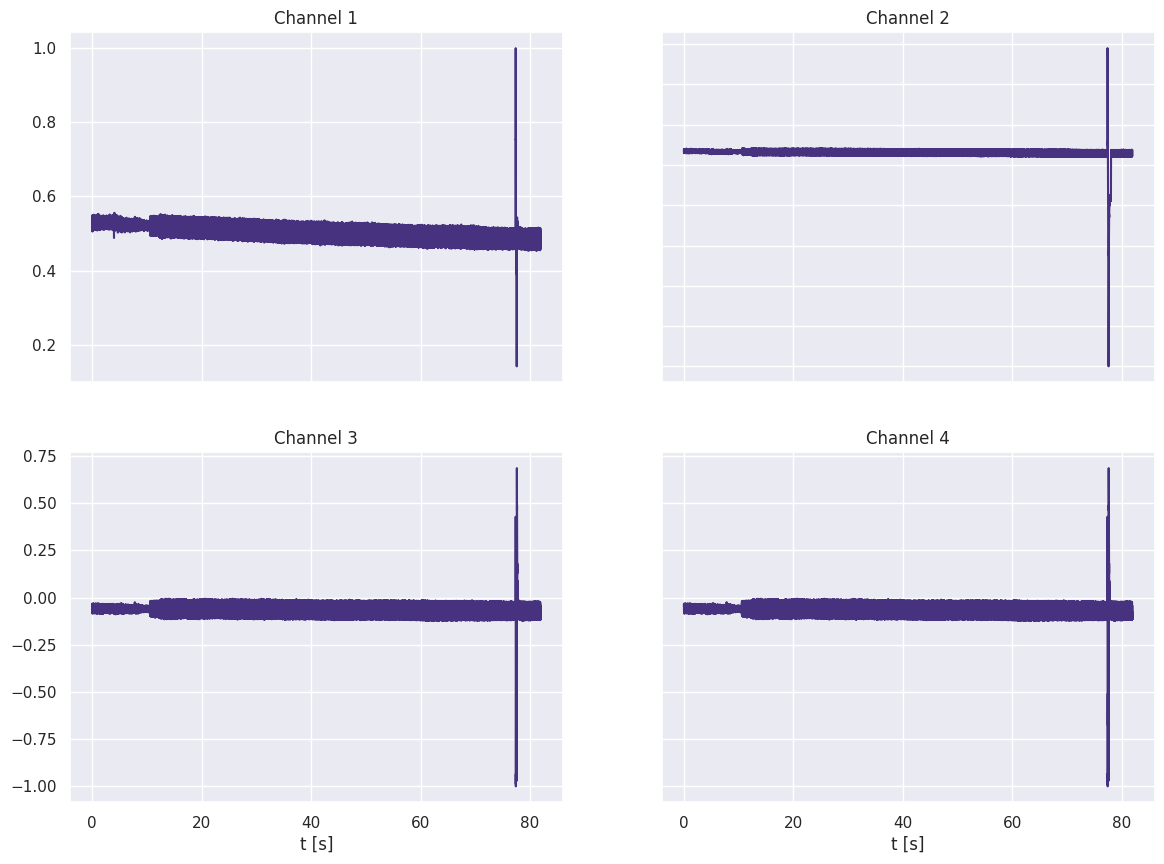

In [94]:
fs = 200
T = 1/fs * len(df_reading)
t = np.linspace(0,T,len(df_reading))

#Normalizamos los canales

channels = [df_reading[f"Channel{i}"] for i in range(1,5)]

[CH1, CH2, CH3, CH4] = channels

CH1 = CH1 / np.max(np.abs(CH1))
CH2 = CH2 / np.max(np.abs(CH2))
CH3 = CH3 / np.max(np.abs(CH3))
CH4 = CH4 / np.max(np.abs(CH4))

fig, axs = plt.subplots(2,2,figsize=(14,10))

axs[0,0].plot(t, CH1)
axs[0,0].set_title("Channel 1")
axs[0,1].plot(t, CH2)
axs[0,1].set_title("Channel 2")
axs[1,0].plot(t, CH3)
axs[1,0].set_title("Channel 3")
axs[1,1].plot(t, CH3)
axs[1,1].set_title("Channel 4")

for ax in axs.flat:
  ax.set(xlabel="t [s]")

for ax in axs.flat:
  ax.label_outer()

channels = [CH1, CH2, CH3, CH4]

<Figure size 640x480 with 0 Axes>

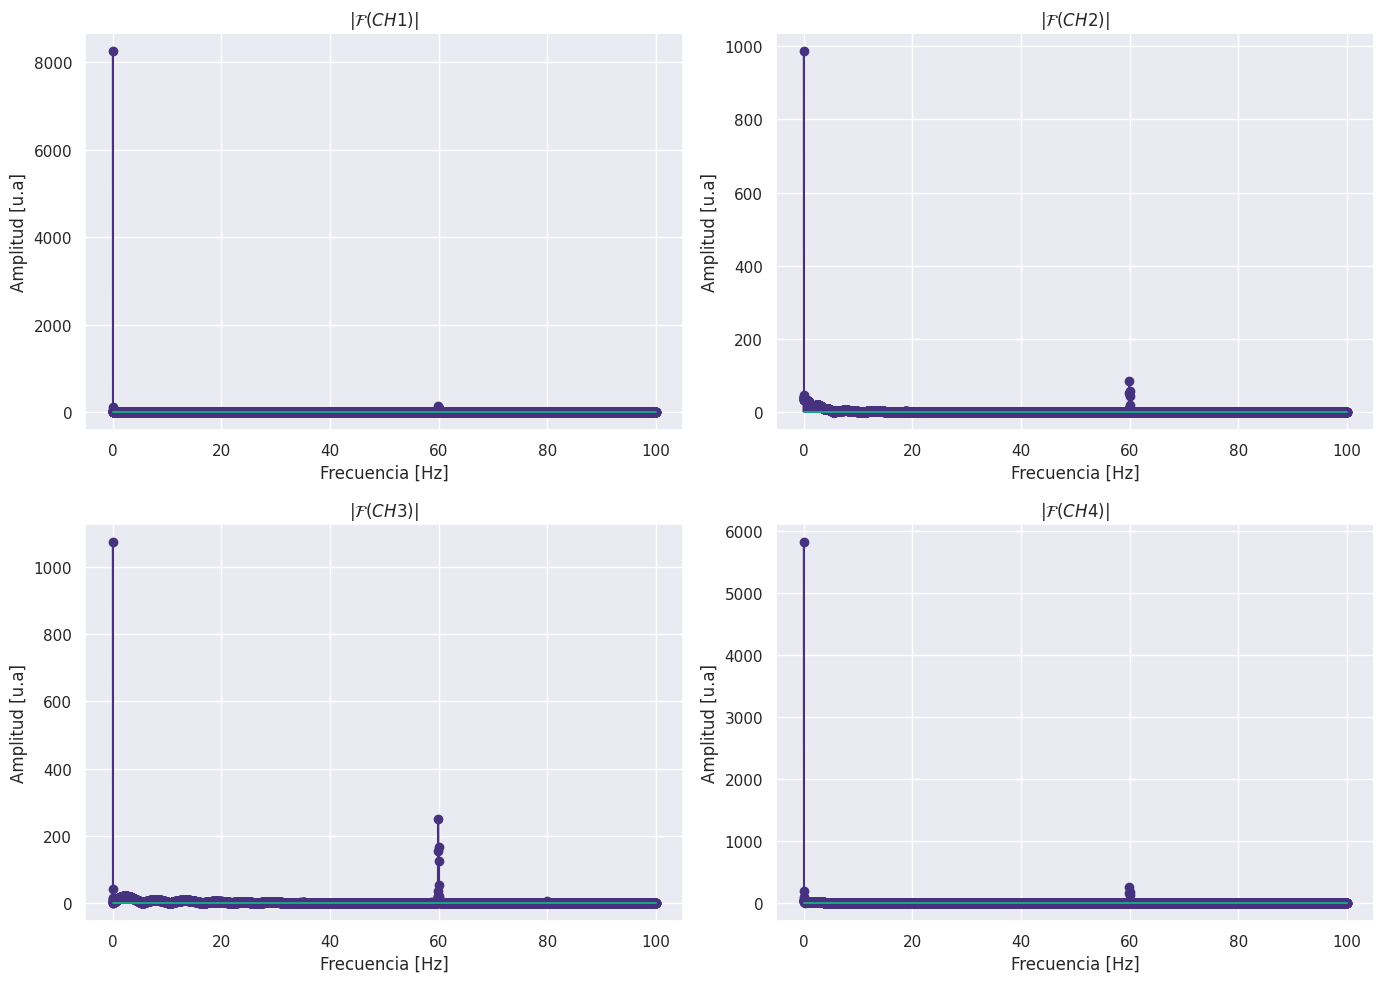

In [95]:
channels_fft, freq = RFFT_CH(channels=channels, fs=fs, freq_size=np.size(t))
plot_channels(channels_fft=channels_fft, freq=freq)

<Figure size 640x480 with 0 Axes>

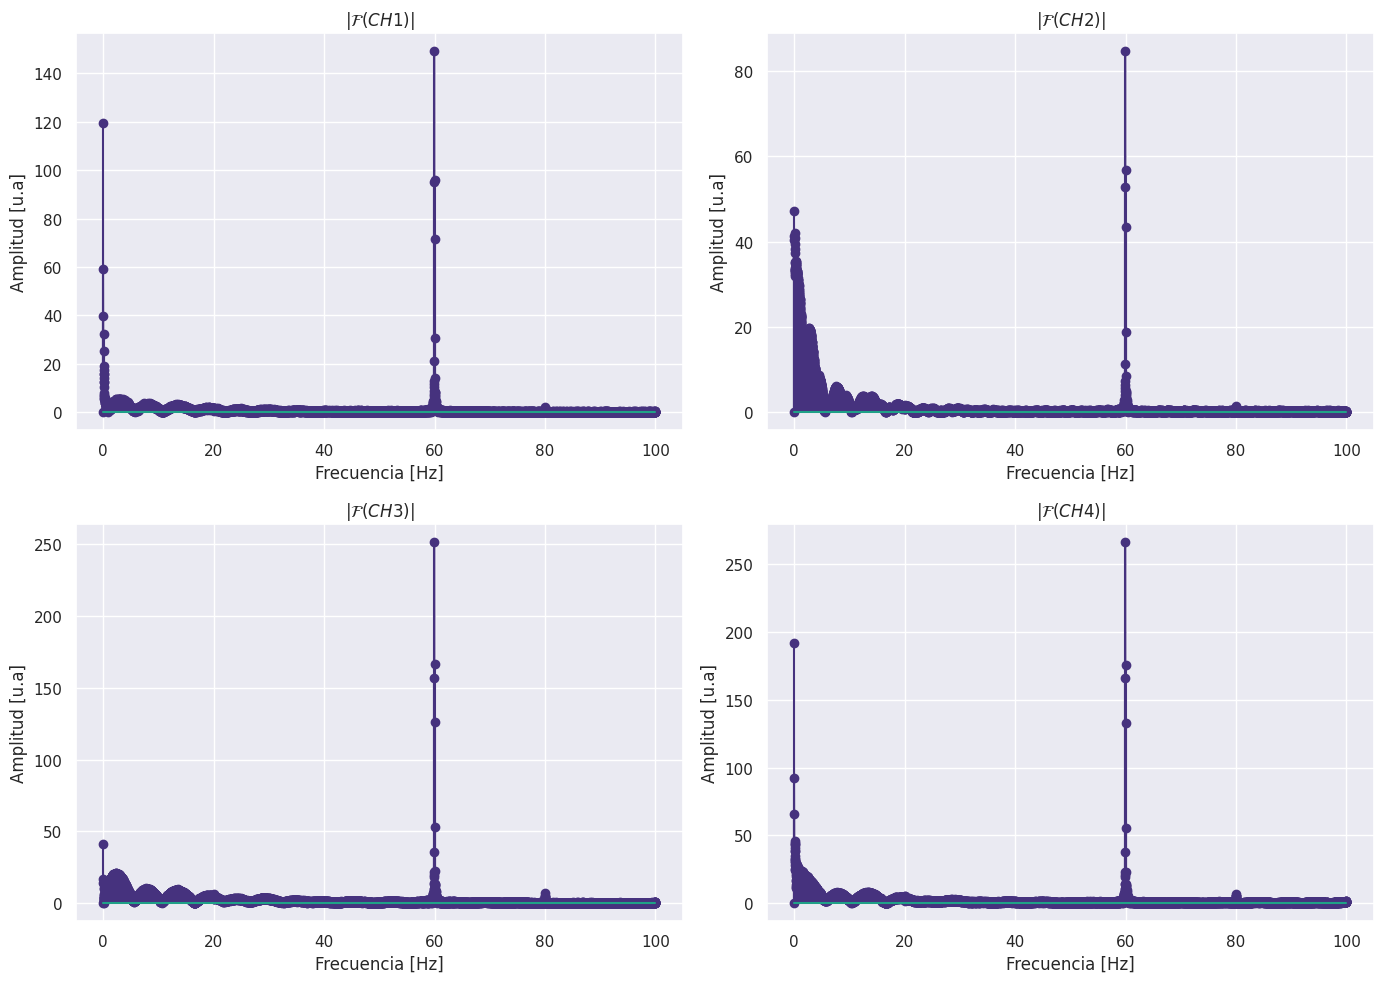

In [96]:
FST_FILT(channels=channels_fft, amp=900)
plot_channels(channels_fft=channels_fft, freq=freq)

<Figure size 640x480 with 0 Axes>

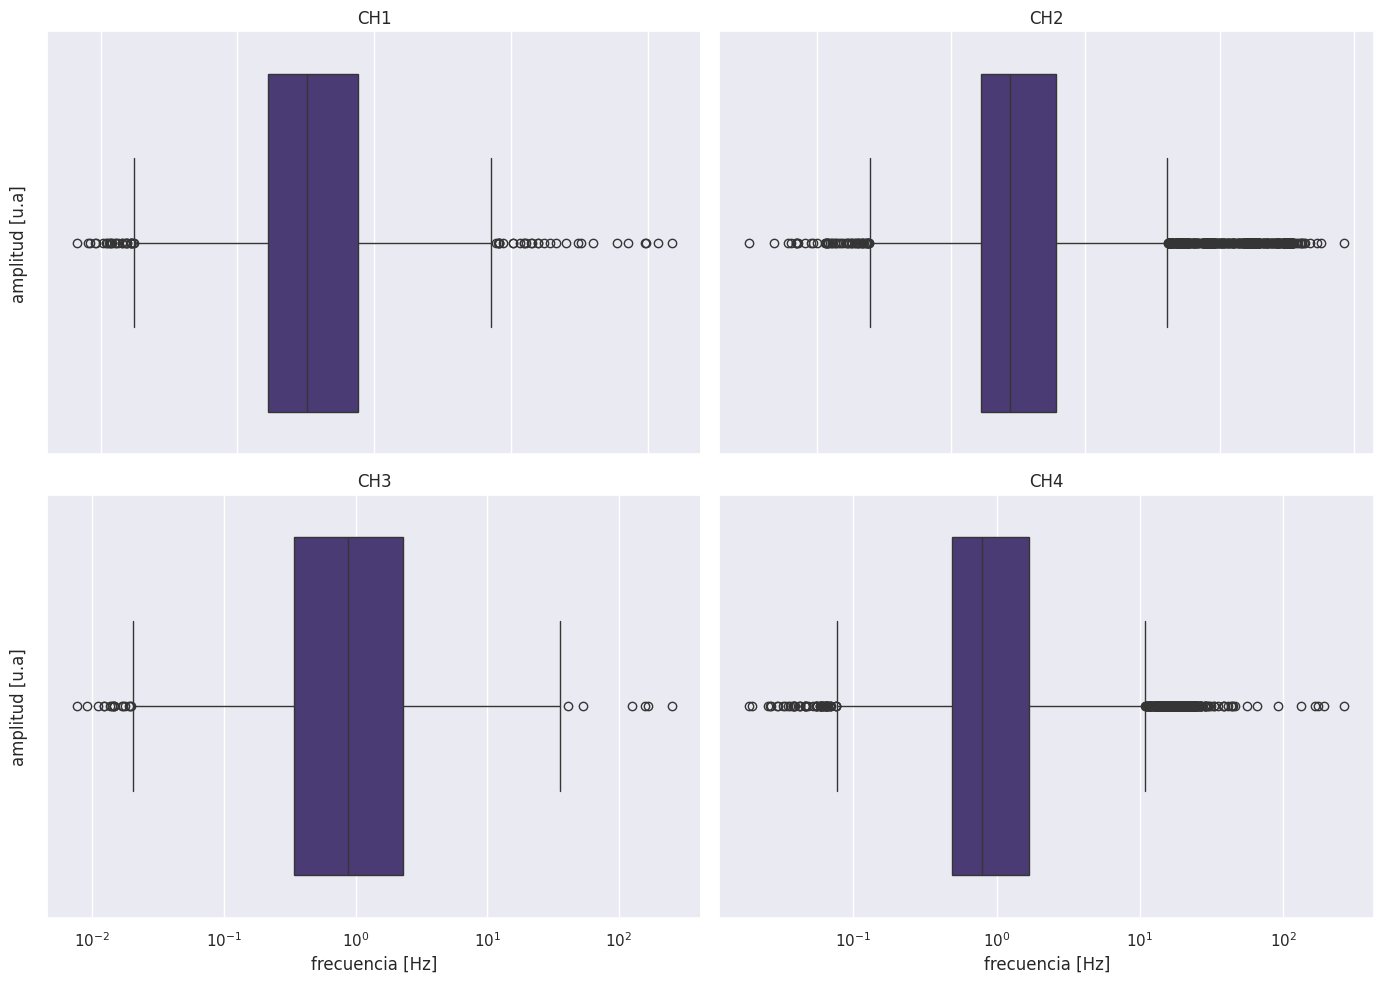

In [97]:
boxplot(channels_fft)

<Figure size 640x480 with 0 Axes>

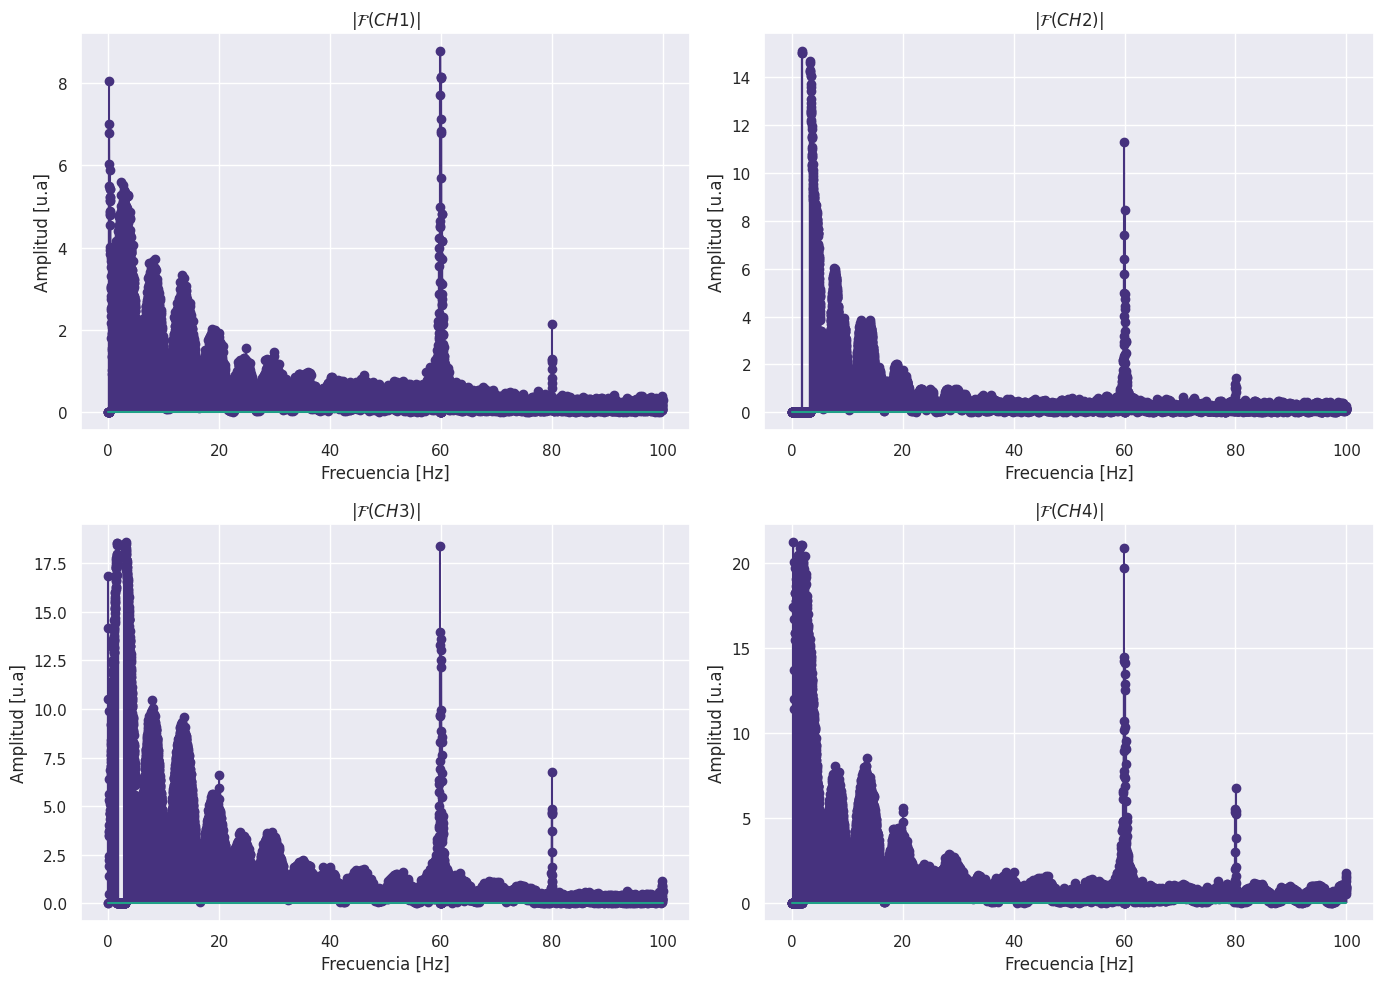

In [98]:
rm_outl(channels=channels_fft, treshold=3)
plot_channels(channels_fft=channels_fft, freq=freq)

<Figure size 640x480 with 0 Axes>

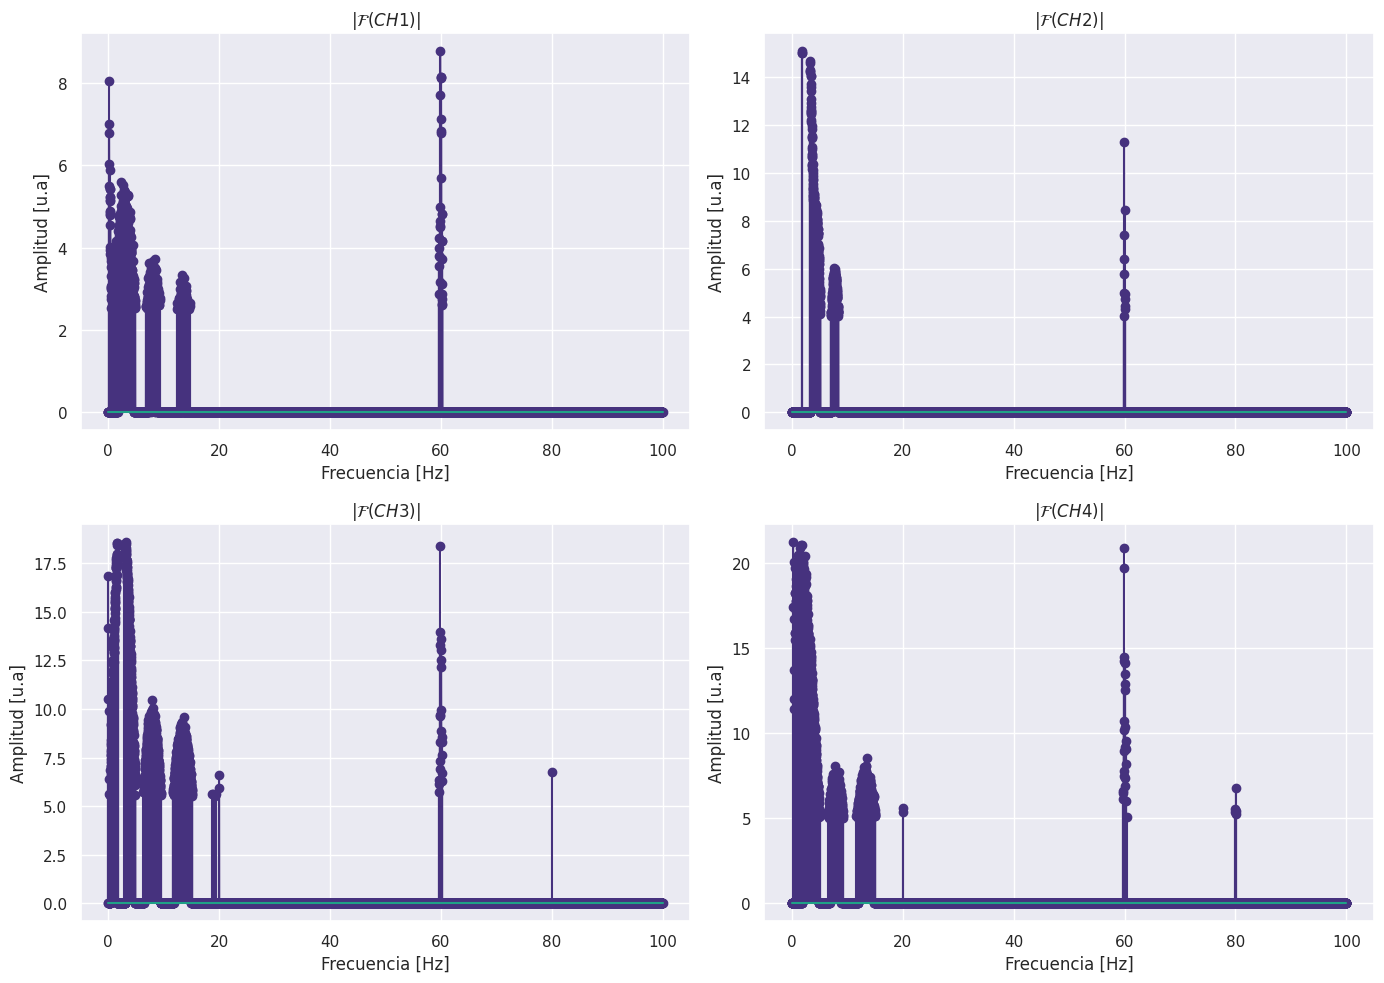

In [99]:
cuts = [2.5,4,5.5,5]

for c, ch in zip(cuts, channels_fft):
    ch[np.abs(ch) < c] = 0

plot_channels(channels_fft=channels_fft, freq=freq)

In [100]:
channels_rec_read = []
for ch in channels_fft:
    channels_rec_read.append(np.fft.irfft(ch))

<Figure size 640x480 with 0 Axes>

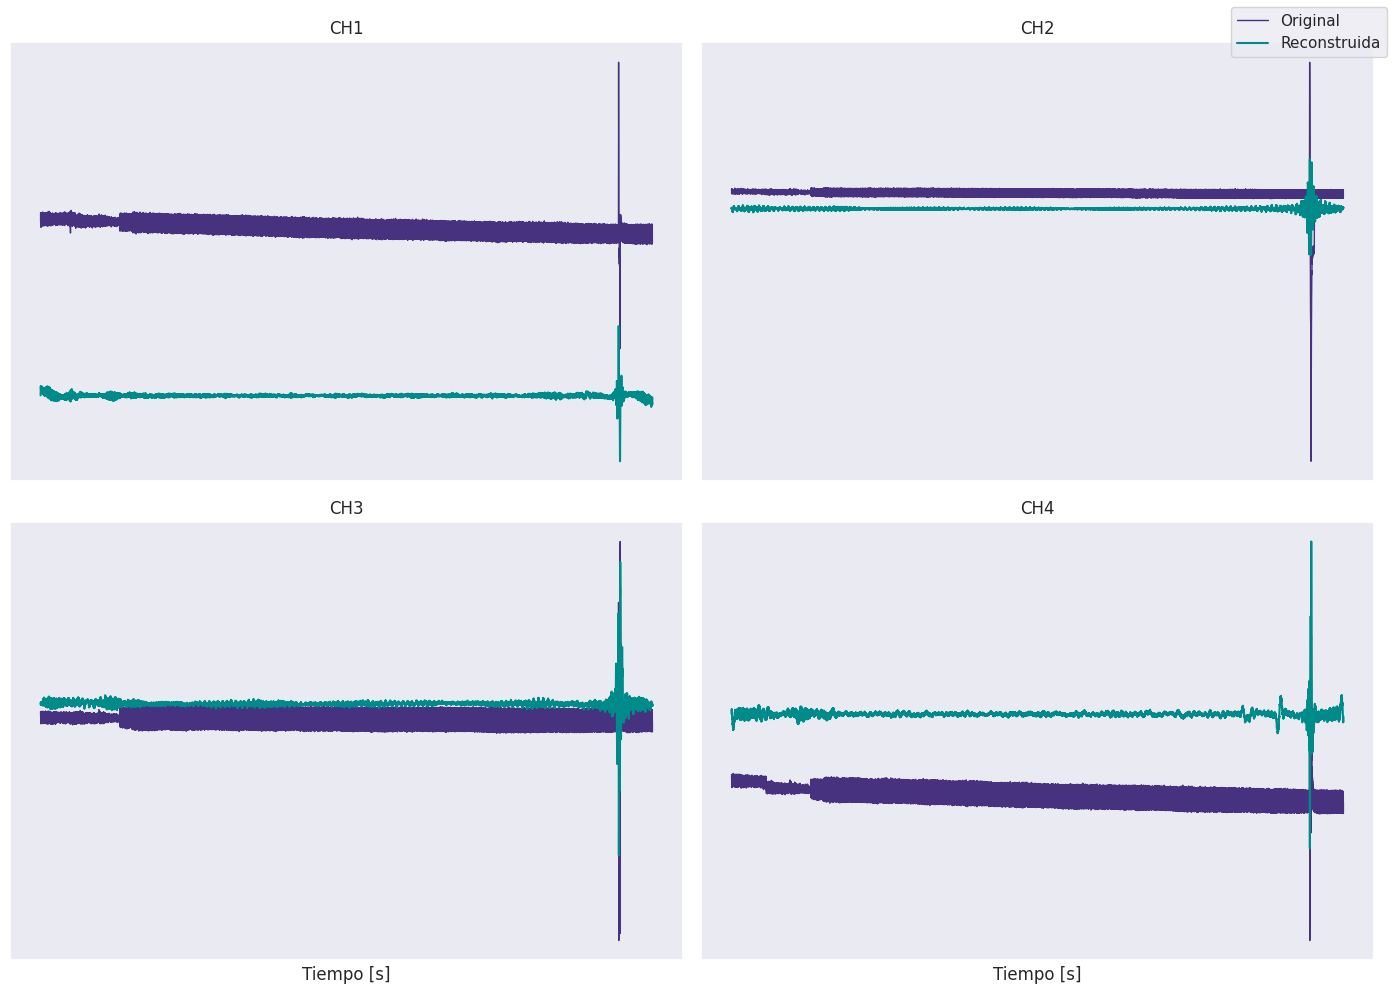

In [101]:
plot_comparison(channels=channels, reconstructed=channels_rec_read, t=t, Tmax=T)

<Figure size 640x480 with 0 Axes>

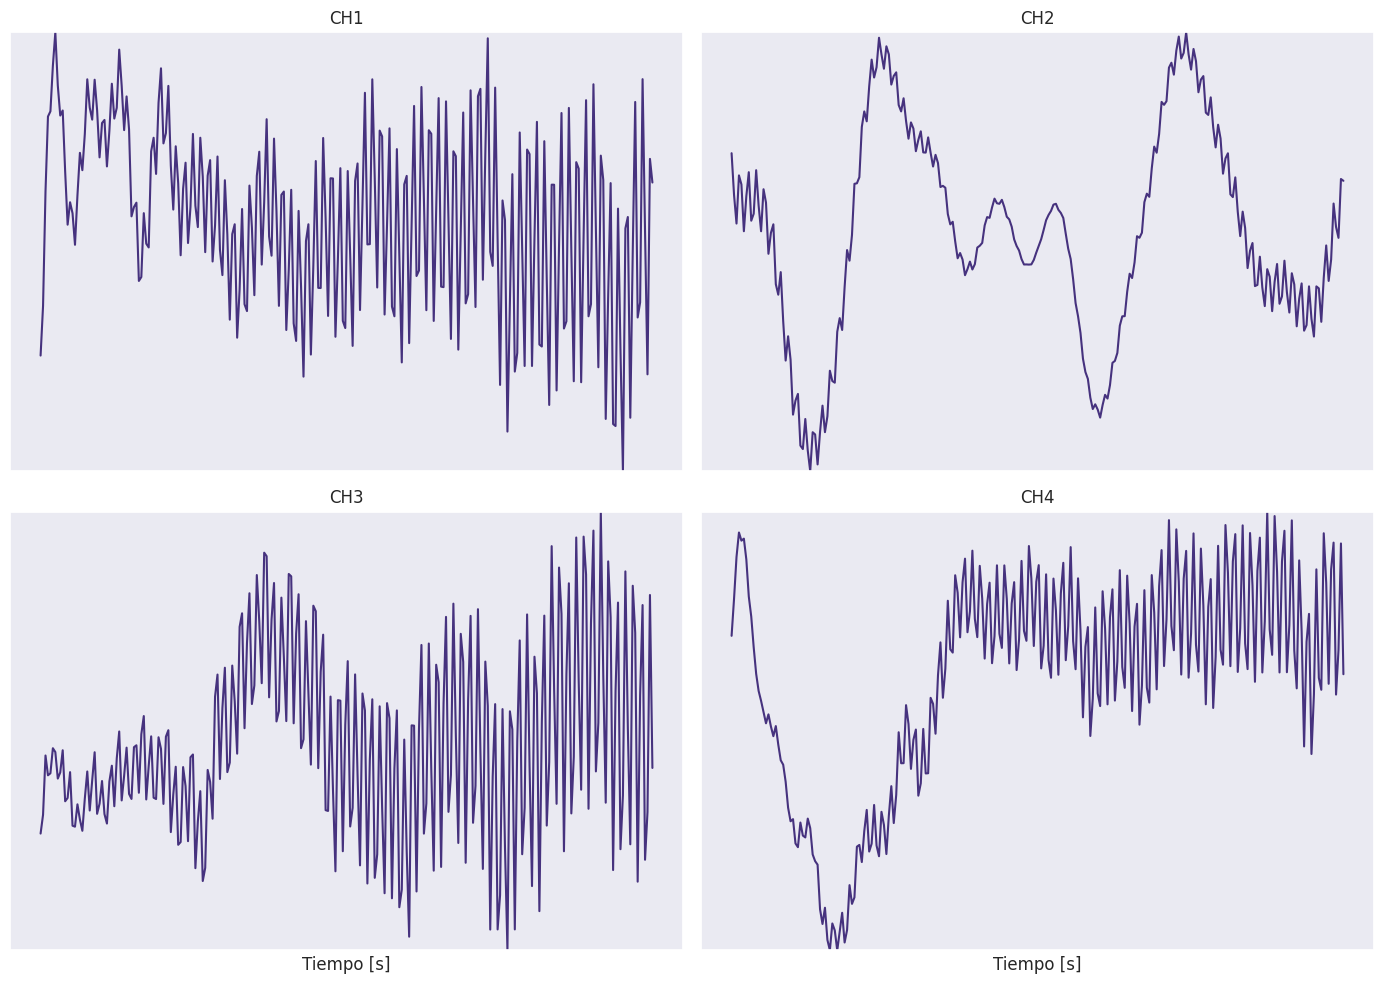

In [103]:
close_up(channels_rec_read, 250, Tmax=T)

## Merge de los datasets para clasificar